# Understanding Hired Rides in NYC

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In this part, we import all the libraries we will use in this project and set some constants to represent the dataset.

In [1]:
# all import statements needed for the project
from math import radians,sin,cos,asin,sqrt
import bs4 
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlite3
import sqlalchemy as db
from sqlalchemy import inspect
import typing
import pytest
import ipytest
import re
import csv
from pandas.testing import assert_frame_equal
import os.path
from __future__ import annotations
import seaborn as sns
import scipy.stats as spst
from keplergl import KeplerGl

In [2]:
# Set constants pointing to dataset
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

### Calculate distance and Add it to the dataset
Step 1: Calculate the distance between two coordinates using the haversine formula:  
Reference from Wikipedia  
![image](https://miro.medium.com/max/1392/0*mie5h2yduk6NmIym)  
Step 2: Add the distance  to the dataset as the new column

In [3]:
def calculate_distance(from_coord:tuple[float,float], to_coord:tuple[float,float]) -> float:
    #Convert decimal number to radian number
    from_lon,from_lat,to_lon,to_lat=map(radians,[from_coord[0],from_coord[1],to_coord[0],to_coord[1]])
    
    #using haversin formula
    dis_lon=to_lon-from_lon
    dis_lat=to_lat-from_lat
    haversine=sin(dis_lat/2)**2+cos(from_lat)*cos(to_lat)*sin(dis_lon/2)**2
    #6371 is the earth's radius(km)
    distance=6371*2*asin(sqrt(haversine))
    #round the result to two decimals
    return round(distance,2)

In [4]:
#TEST FOR calculate_distance()
#TEST BEGINS
@pytest.mark.parametrize(
    "from_coord,to_coord,expected",
    (
        ((-73.99981689,40.73835373),(-73.99951172,40.72321701),1.68),
        ((-73.994355,40.728225),(-73.99471,40.750325),2.46),
        ((-73.78808,40.642187),(-73.865042,40.725997),11.36),
        ((-73.992122,40.748577),(-73.806072,40.665272),18.21),
        ((-73.982321,40.768729),(-73.921654,40.660043),13.12),
    )
)

def test_calculate_distance(from_coord:tuple[float,float],to_coord,expected:tuple[float,float]) -> None:
    assert expected==calculate_distance(from_coord,to_coord)

ipytest.run("-vv", "-k", "test_calculate_distance")
#TEST ENDS

======================================= test session starts ========================================
platform darwin -- Python 3.8.8, pytest-6.2.3, py-1.10.0, pluggy-0.13.1 -- /Users/keying/opt/anaconda3/bin/python
cachedir: .pytest_cache
rootdir: /Users/keying/Documents/GitHub/Python-Final-Project-Data-Analytics-
plugins: anyio-2.2.0
collecting ... collected 5 items

tmpdjz8a2m_.py::test_calculate_distance[from_coord0-to_coord0-1.68] <- <ipython-input-4-9a5ba3d54cfd> PASSED [ 20%]
tmpdjz8a2m_.py::test_calculate_distance[from_coord1-to_coord1-2.46] <- <ipython-input-4-9a5ba3d54cfd> PASSED [ 40%]
tmpdjz8a2m_.py::test_calculate_distance[from_coord2-to_coord2-11.36] <- <ipython-input-4-9a5ba3d54cfd> PASSED [ 60%]
tmpdjz8a2m_.py::test_calculate_distance[from_coord3-to_coord3-18.21] <- <ipython-input-4-9a5ba3d54cfd> PASSED [ 80%]
tmpdjz8a2m_.py::test_calculate_distance[from_coord4-to_coord4-13.12] <- <ipython-input-4-9a5ba3d54cfd> PASSED [100%]

======================================== 5 pa

<ExitCode.OK: 0>

In [5]:
#Add distance to the dataset
def add_distance_column(df:pd.DataFrame) -> None:
    distance=[]
    for i,row in df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].iterrows():
        distance.append(calculate_distance((row['pickup_longitude'],row['pickup_latitude']),(row['dropoff_longitude'],row['dropoff_latitude'])))
    df['trip_distance']=distance
    #add distance to the new column 'trip_distance'

In [6]:
# TEST FOR add_distance_column
# TEST BEGINS
test_data = pd.DataFrame(
    {
        "pickup_longitude": [-73.99981689, -73.994355],
        "pickup_latitude": [40.73835373, 40.728225],
        "dropoff_longitude": [-73.99951172, -73.99471],
        "dropoff_latitude": [40.72321701, 40.750325],
    }
)
expected_data = pd.DataFrame(
    {
        "pickup_longitude": [-73.99981689, -73.994355],
        "pickup_latitude": [40.73835373, 40.728225],
        "dropoff_longitude": [-73.99951172, -73.99471],
        "dropoff_latitude": [40.72321701, 40.750325],
        "trip_distance": [1.68, 2.46],
    }
)


def test_add_distance() -> None:
    add_distance_column(test_data)
    assert_frame_equal(test_data, expected_data)


ipytest.run("-vv", "-k", "test_add_distance")
# TEST ENDS


======================================= test session starts ========================================
platform darwin -- Python 3.8.8, pytest-6.2.3, py-1.10.0, pluggy-0.13.1 -- /Users/keying/opt/anaconda3/bin/python
cachedir: .pytest_cache
rootdir: /Users/keying/Documents/GitHub/Python-Final-Project-Data-Analytics-
plugins: anyio-2.2.0
collecting ... collected 6 items / 5 deselected / 1 selected

tmp59usdil_.py::test_add_distance <- <ipython-input-6-a89c123351e3> PASSED                   [100%]

================================= 1 passed, 5 deselected in 0.01s ==================================


<ExitCode.OK: 0>

### Processing Uber Data

* Clean the data, including:
  * Remove unnecessary columns
  * Remove invalid data points
  * Remove trips that start and/or end outside the designated NEW_YORK_BOX_COORDS  
  

* Calculate the sample size for each month and so we can use it later to sample the Yellow taxi dataset

In [7]:
# load and clean data
def load_and_clean_uber_data(csv_file:str) -> pd.DataFrame:
    df = pd.read_csv(csv_file)
    # only pick the columns that will be used later
    df=df[['fare_amount','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
    # Remove trips that start and/or end outside the designated coordinate box
    df = df[
        (df["pickup_longitude"] <= NEW_YORK_BOX_COORDS[1][1])
        & (NEW_YORK_BOX_COORDS[0][1] <= df["pickup_longitude"])
        & (df["pickup_latitude"] <= NEW_YORK_BOX_COORDS[1][0])
        & (NEW_YORK_BOX_COORDS[0][0] <= df["pickup_latitude"])
        & (df["dropoff_longitude"] <= NEW_YORK_BOX_COORDS[1][1])
        & (NEW_YORK_BOX_COORDS[0][1] <= df["dropoff_longitude"])
        & (df["dropoff_latitude"] <= NEW_YORK_BOX_COORDS[1][0])
        & (NEW_YORK_BOX_COORDS[0][0] <= df["dropoff_latitude"])
    ]
    # set column 'pickup_datetime' to datetime type
    df['pickup_datetime'] = df['pickup_datetime'].apply(lambda x: x.replace(' UTC', ''))
    # delete invalid data points where the fare_amount is 0
    return df[(df["fare_amount"] != 0)]

# get the whole cleaned dataset
def get_uber_data() -> pd.DataFrame:
    # get the cleaned data and add trip_distance column to it
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe


In [8]:
# calculate the sample size for each month
def get_sample_size(df:pd.DataFrame) -> dict:
    #group the data by the month
    df_month=df.groupby(df['pickup_datetime'].str[:7]).count()
    sample_size={}
    #store the month and sample size to the dict
    for month, size in df_month[['fare_amount']].iterrows():
        sample_size[month] = size.values[0]
    return sample_size

In [9]:
# run all functions and get the dataset
uber_data = get_uber_data()
sample_size=get_sample_size(uber_data)

In [10]:
# show the uber dataset
uber_data

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1.68
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,2.46
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,5.04
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,1.66
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,4.48
...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00,-73.987042,40.739367,-73.986525,40.740297,0.11
199996,7.5,2014-03-14 01:09:00,-73.984722,40.736837,-74.006672,40.739620,1.88
199997,30.9,2009-06-29 00:42:00,-73.986017,40.756487,-73.858957,40.692588,12.85
199998,14.5,2015-05-20 14:56:25,-73.997124,40.725452,-73.983215,40.695415,3.54


In [11]:
# show the sample size
print(sample_size)

{'2009-01': 2504, '2009-02': 2261, '2009-03': 2665, '2009-04': 2531, '2009-05': 2619, '2009-06': 2495, '2009-07': 2454, '2009-08': 2386, '2009-09': 2448, '2009-10': 2606, '2009-11': 2479, '2009-12': 2629, '2010-01': 2618, '2010-02': 1909, '2010-03': 2337, '2010-04': 2690, '2010-05': 2739, '2010-06': 2544, '2010-07': 2536, '2010-08': 2204, '2010-09': 2422, '2010-10': 2573, '2010-11': 2455, '2010-12': 2466, '2011-01': 2346, '2011-02': 2511, '2011-03': 2768, '2011-04': 2607, '2011-05': 2681, '2011-06': 2738, '2011-07': 2515, '2011-08': 2340, '2011-09': 2577, '2011-10': 2797, '2011-11': 2623, '2011-12': 2599, '2012-01': 2592, '2012-02': 2642, '2012-03': 2822, '2012-04': 2740, '2012-05': 2722, '2012-06': 2524, '2012-07': 2516, '2012-08': 2548, '2012-09': 2611, '2012-10': 2617, '2012-11': 2525, '2012-12': 2672, '2013-01': 2598, '2013-02': 2417, '2013-03': 2739, '2013-04': 2677, '2013-05': 2547, '2013-06': 2558, '2013-07': 2455, '2013-08': 2237, '2013-09': 2547, '2013-10': 2668, '2013-11': 25

### Processing Taxi Data

* use regular expression to find all the taxi csv file urls
* Use `requests`, BeautifulSoup (`bs4`), and `pandas` to programmatically download the required CSV files & load into memory.
* Clean the data, including:
    * Remove unnecessary columns
    * Remove invalid data points (take a moment to consider what's invalid)
    * Normalize column names
    * Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
* Sample the data so that we have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* Cache the sampling by saving it as a CSV file before moving onto the next file. 

In [12]:
# find all the taxi csv file urls
def find_taxi_csv_urls() -> list:
    taxi_page = requests.get(TAXI_URL)
    soup = bs4.BeautifulSoup(taxi_page.text, "html.parser")
    # create a pattern matching the taxi data csv files.
    pattern = re.compile(
        "https:\/\/s3\.amazonaws\.com\/nyc-tlc\/trip\+data\/yellow_tripdata_\d{4}-\d{2}\.csv"
    )
    # get all urls
    all_href = [a["href"] for a in soup.find_all("a")]
    # match the pattern with all urls and find out csv files urls
    all_url = pattern.findall("".join(all_href))
    # only select urls from 2009-01 to 2015-06
    all_url = all_url[54:60] + all_url[66:]
    return all_url


# Normalize all csv files col names to the same column names
def normalize_col_name(df: pd.DataFrame) -> pd.DataFrame:
    # get the original col names
    col_names = df.columns
    col_names = ",".join(col_names).split(",")
    # Set all the names to the following new names
    col_newname = [
        "pickup_datetime",
        "dropoff_datetime",
        "pickup_longitude",
        "pickup_latitude",
        "dropoff_longitude",
        "dropoff_latitude",
        "tip_amount",
        "total_amount",
    ]
    col_oldname = []
    # find all the old col needed to be changed
    pattern1 = ".*[Tt]ime.*"
    pattern2 = ".*[Ll]on.*"
    pattern3 = ".*[Ll]at.*"
    pattern4 = ".*[Tt]ip.*"
    pattern5 = ".*[Tt]otal.*"
    for i in col_names:
        if re.findall(pattern1, i) != []:
            col_oldname.append(re.findall(pattern1, i)[0])
        if re.findall(pattern2, i) != []:
            col_oldname.append(re.findall(pattern2, i)[0])
        if re.findall(pattern3, i) != []:
            col_oldname.append(re.findall(pattern3, i)[0])
        if re.findall(pattern4, i) != []:
            col_oldname.append(re.findall(pattern4, i)[0])
        if re.findall(pattern5, i) != []:
            col_oldname.append(re.findall(pattern5, i)[0])
    # assign old col names and new col names to a dict
    name_dict = dict(zip(col_oldname, col_newname))
    # change col names
    df.rename(columns=name_dict, inplace=True)
    # We only select part of the columns and remove unnecessary columns
    return df[col_newname]


# load and clean data
# if the csv files has been saved before, then load it directly from the computer
def get_and_clean_month_taxi_data(url: str) -> pd.DataFrame:
    # get the month from url
    month = url[59:66]
    taxi_sample = sample_size[month]
    file_exists = os.path.exists(f"taxi_{month}.csv")
    # if file already saved, then load it from the computer
    if file_exists == True:
        df = pd.read_csv(f"taxi_{month}.csv")
    # if file haven't been saved, then load it from the URL.
    else:
        df = pd.read_csv(url,on_bad_lines='skip')
        # Normalize the col names and delete other unnecessary columns
        df = normalize_col_name(df)
        # delete invalid data points where total_amount is zero.
        df = df[(df["total_amount"] != 0)]
        # remove trips that start or/and end out of NEW_YORK_BOX_COORDS
        df = df[
            (df["pickup_longitude"] <= NEW_YORK_BOX_COORDS[1][1])
            & (NEW_YORK_BOX_COORDS[0][1] <= df["pickup_longitude"])
            & (df["pickup_latitude"] <= NEW_YORK_BOX_COORDS[1][0])
            & (NEW_YORK_BOX_COORDS[0][0] <= df["pickup_latitude"])
            & (df["dropoff_longitude"] <= NEW_YORK_BOX_COORDS[1][1])
            & (NEW_YORK_BOX_COORDS[0][1] <= df["dropoff_longitude"])
            & (df["dropoff_latitude"] <= NEW_YORK_BOX_COORDS[1][0])
            & (NEW_YORK_BOX_COORDS[0][0] <= df["dropoff_latitude"])
        ]
        # Sample the data so that we have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
        df = df.sample(n=taxi_sample, random_state=1)
        df.to_csv(f"taxi_{month}.csv")
    return df

# get the whole cleaned taxi data
def get_and_clean_taxi_data() ->pd.DataFrame:
    all_taxi_dataframes = []
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        dataframe = get_and_clean_month_taxi_data(csv_url)
        # Add trip_distance column to the dataset
        add_distance_column(dataframe)
        all_taxi_dataframes.append(dataframe)
    # concat all the dataframes together to one dataframe
    taxi_data = pd.concat(all_taxi_dataframes)
    taxi_data = taxi_data[
    [
        "pickup_datetime",
        "dropoff_datetime",
        "pickup_longitude",
        "pickup_latitude",
        "dropoff_longitude",
        "dropoff_latitude",
        "tip_amount",
        "total_amount",
        "trip_distance",
    ]
]
    return taxi_data


In [13]:
# run all the functions and get the dataset
taxi_data = get_and_clean_taxi_data()

In [14]:
# show taxi data
taxi_data

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,total_amount,trip_distance
0,2015-01-13 07:03:21,2015-01-13 07:07:44,-73.961639,40.811272,-73.972099,40.794521,0.00,6.80,2.06
1,2015-01-22 04:24:33,2015-01-22 04:32:29,-73.967201,40.765133,-73.967201,40.765133,0.00,9.80,0.00
2,2015-01-11 02:13:11,2015-01-11 02:21:22,-73.993866,40.756718,-74.000473,40.740696,0.00,8.80,1.87
3,2015-01-31 23:07:04,2015-01-31 23:18:06,-73.996567,40.745354,-73.999924,40.725662,0.00,10.80,2.21
4,2015-01-28 12:19:09,2015-01-28 12:25:33,-73.955078,40.783367,-73.954170,40.774845,1.36,8.16,0.95
...,...,...,...,...,...,...,...,...,...
2624,2009-12-24 15:22:00,2009-12-24 15:30:00,-73.989560,40.747138,-73.975782,40.765718,0.00,7.00,2.37
2625,2009-12-21 12:15:40,2009-12-21 12:21:11,-73.936727,40.653765,-73.939208,40.652818,0.93,7.13,0.23
2626,2009-12-28 13:14:00,2009-12-28 13:17:00,-73.968078,40.762090,-73.960922,40.769287,0.00,4.60,1.00
2627,2009-12-12 14:33:19,2009-12-12 14:45:49,-73.978040,40.766393,-74.017330,40.711000,0.00,16.20,6.99


### Processing Weather Data

* Remove unnecessary columns that won't be used later
* Fill NaN values with zero because NaN means observe nothing
* Get the hourly and daily weather data
* Daily weather data is about all the daily mean of HourlyPrecipitation and HourlyWindSpeed



In [15]:
# Clean weather data and delete unnecessary columns
def clean_month_weather_data_hourly(csv_file: str) -> pd.DataFrame:
    df=pd.read_csv(csv_file,low_memory=False)
    # only get columns we need later
    df=df[['DATE','HourlyPrecipitation','HourlyWindSpeed']]\
    # delete 'T' in date column
    df['DATE'] = df['DATE'].apply(lambda x: x.replace('T',' '))
    # change date column into hour format
    df['DATE'] = df['DATE'].apply(lambda x: x[:13]+':00:00')
    # fill NaN values with zero because NaN means there is no precipitation.
    df.fillna(0.00,inplace=True)
    # T means very trace precipitation, to simplify, we set it as zero.
    df['HourlyPrecipitation'].replace({'T':0.00},inplace=True)
    # convert the datatype to float
    df['HourlyPrecipitation']=pd.to_numeric(df['HourlyPrecipitation'],errors='coerce')
    # We only collect data to Jun 2015
    if(csv_file[:4]=='2015'):
        df=df.iloc[:5826]
    # sum data by hour
    df = df.groupby('DATE')[['HourlyPrecipitation', 'HourlyWindSpeed']].sum().reset_index()
    return df

# Group weather data by the same date and calculate the daily mean of HourlyPrecipitation and HourlyWindSpeed
def clean_month_weather_data_daily(csv_file: str) -> pd.DataFrame:
    df=clean_month_weather_data_hourly(csv_file)
    df=df.groupby(df['DATE'].str[:10]).mean()
    return df

# load and clean data
def load_and_clean_weather_data() -> pd.DataFrame:
    hourly_dataframes = []
    daily_dataframes = []

    weather_csv_files = ["2009_weather.csv","2010_weather.csv","2011_weather.csv","2012_weather.csv","2013_weather.csv","2014_weather.csv","2015_weather.csv"]

    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)

    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    return hourly_data, daily_data


In [16]:
# run all the function and get the dataset
hourly_weather, daily_weather = load_and_clean_weather_data()

In [17]:
# show the hourly weather dataset
hourly_weather

,DATE,HourlyPrecipitation,HourlyWindSpeed
0,2009-01-01 00:00:00,0.00,18.0
1,2009-01-01 01:00:00,0.00,18.0
2,2009-01-01 02:00:00,0.00,18.0
3,2009-01-01 03:00:00,0.00,8.0
4,2009-01-01 04:00:00,0.00,11.0
...,...,...,...
4339,2015-06-30 19:00:00,0.00,23.0
4340,2015-06-30 20:00:00,0.00,5.0
4341,2015-06-30 21:00:00,0.00,7.0
4342,2015-06-30 22:00:00,0.00,5.0


In [18]:
# show the daily weather dataset
daily_weather

,HourlyPrecipitation,HourlyWindSpeed
DATE,,
2009-01-01,0.000000,11.041667
2009-01-02,0.000000,8.791667
2009-01-03,0.000000,9.875000
2009-01-04,0.000000,8.291667
2009-01-05,0.000000,7.791667
...,...,...
2015-06-26,0.000000,4.583333
2015-06-27,0.111250,13.791667
2015-06-28,0.025000,9.541667


## Part 2: Storing Cleaned Data

* Delete database if exists before
* Create a new database
* Using the schema to create four tables
* Add dataframes to the database
* Show all tables

In [19]:
# check if the database already exists
file_exists = os.path.exists("project.db")
# if the database exists, then delete it because we need create a totally new database
if(file_exists==True):
    os.remove("project.db")
# create a new SQLite database named project
engine = db.create_engine(DATABASE_URL,echo=True)
# use schema.sql to create four tables schema
!sqlite3 project.db < schema.sql

In [20]:
# Add four dataframes to the database
# Don't run this cell multiple times because it will append the same dataframe again and again.
uber_data.to_sql('uber_trips',con=engine,if_exists='append',index=False)
taxi_data.to_sql('taxi_trips',con=engine,if_exists='append',index=False)
hourly_weather.to_sql('hourly_weather',con=engine,if_exists='append',index=False)
daily_weather.to_sql('daily_weather',con=engine,if_exists='append')

2022-04-29 14:26:18,769 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("uber_trips")
2022-04-29 14:26:18,769 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-29 14:26:18,833 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-29 14:26:19,861 INFO sqlalchemy.engine.Engine INSERT INTO uber_trips (fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance) VALUES (?, ?, ?, ?, ?, ?, ?)
2022-04-29 14:26:19,862 INFO sqlalchemy.engine.Engine [generated in 0.88415s] ((7.5, '2015-05-07 19:52:06', -73.99981689453125, 40.73835372924805, -73.99951171875, 40.72321701049805, 1.68), (7.7, '2009-07-17 20:04:56', -73.994355, 40.728225, -73.99471, 40.750325, 2.46), (12.9, '2009-08-24 21:45:00', -74.005043, 40.74077, -73.962565, 40.772647, 5.04), (5.3, '2009-06-26 08:22:21', -73.976124, 40.790844, -73.965316, 40.803349, 1.66), (16.0, '2014-08-28 17:47:00', -73.925023, 40.744085, -73.97308199999999, 40.761247, 4.48), (4.9, '2011-02-12 02:

2367

In [21]:
# show uber_trips table
engine.execute("SELECT * FROM uber_trips").fetchall()

2022-04-29 14:26:21,909 INFO sqlalchemy.engine.Engine SELECT * FROM uber_trips
2022-04-29 14:26:21,909 INFO sqlalchemy.engine.Engine [raw sql] ()


[(1, 7.5, '2015-05-07 19:52:06', -73.99981689453125, 40.73835372924805, -73.99951171875, 40.72321701049805, 1.68),
 (2, 7.7, '2009-07-17 20:04:56', -73.994355, 40.728225, -73.99471, 40.750325, 2.46),
 (3, 12.9, '2009-08-24 21:45:00', -74.005043, 40.74077, -73.962565, 40.772647, 5.04),
 (4, 5.3, '2009-06-26 08:22:21', -73.976124, 40.790844, -73.965316, 40.803349, 1.66),
 (5, 16.0, '2014-08-28 17:47:00', -73.925023, 40.744085, -73.97308199999999, 40.761247, 4.48),
 (6, 4.9, '2011-02-12 02:27:09', -73.96901899999999, 40.75591, -73.96901899999999, 40.75591, 0.0),
 (7, 24.5, '2014-10-12 07:04:00', -73.96144699999999, 40.693965000000006, -73.871195, 40.774297, 11.73),
 (8, 9.7, '2012-02-17 09:32:00', -73.975187, 40.745767, -74.00272, 40.743537, 2.33),
 (9, 12.5, '2012-03-29 19:06:00', -74.001065, 40.741787, -73.96304, 40.775012, 4.89),
 (10, 6.5, '2015-05-22 17:32:27', -73.9743881225586, 40.74695205688477, -73.98858642578125, 40.729804992675774, 2.25),
 (11, 3.3, '2011-05-17 14:03:00', -73.9

In [22]:
# show taxi_trips table
engine.execute("SELECT * FROM taxi_trips").fetchall()

2022-04-29 14:26:22,574 INFO sqlalchemy.engine.Engine SELECT * FROM taxi_trips
2022-04-29 14:26:22,574 INFO sqlalchemy.engine.Engine [raw sql] ()


[(1, '2015-01-13 07:03:21', '2015-01-13 07:07:44', -73.96163940429686, 40.81127166748047, -73.97209930419923, 40.79452133178711, 0.0, 6.8, 2.06),
 (2, '2015-01-22 04:24:33', '2015-01-22 04:32:29', -73.96720123291014, 40.765132904052734, -73.96720123291014, 40.765132904052734, 0.0, 9.8, 0.0),
 (3, '2015-01-11 02:13:11', '2015-01-11 02:21:22', -73.99386596679686, 40.756717681884766, -74.00047302246092, 40.74069595336913, 0.0, 8.8, 1.87),
 (4, '2015-01-31 23:07:04', '2015-01-31 23:18:06', -73.99656677246092, 40.74535369873047, -73.99992370605469, 40.72566223144531, 0.0, 10.8, 2.21),
 (5, '2015-01-28 12:19:09', '2015-01-28 12:25:33', -73.955078125, 40.783367156982415, -73.95417022705078, 40.774845123291016, 1.36, 8.16, 0.95),
 (6, '2015-01-08 20:32:12', '2015-01-08 20:39:58', -73.97823333740233, 40.7543830871582, -73.98754119873048, 40.73903274536133, 1.65, 9.95, 1.88),
 (7, '2015-01-16 07:23:28', '2015-01-16 07:33:42', -73.95301818847656, 40.77254867553711, -73.97560882568358, 40.75502777

In [23]:
# show hourly_weather table
engine.execute("SELECT * FROM hourly_weather").fetchall()

2022-04-29 14:26:23,406 INFO sqlalchemy.engine.Engine SELECT * FROM hourly_weather
2022-04-29 14:26:23,407 INFO sqlalchemy.engine.Engine [raw sql] ()


[(1, '2009-01-01 00:00:00', 0.0, 18.0),
 (2, '2009-01-01 01:00:00', 0.0, 18.0),
 (3, '2009-01-01 02:00:00', 0.0, 18.0),
 (4, '2009-01-01 03:00:00', 0.0, 8.0),
 (5, '2009-01-01 04:00:00', 0.0, 11.0),
 (6, '2009-01-01 05:00:00', 0.0, 18.0),
 (7, '2009-01-01 06:00:00', 0.0, 14.0),
 (8, '2009-01-01 07:00:00', 0.0, 8.0),
 (9, '2009-01-01 08:00:00', 0.0, 15.0),
 (10, '2009-01-01 09:00:00', 0.0, 8.0),
 (11, '2009-01-01 10:00:00', 0.0, 14.0),
 (12, '2009-01-01 11:00:00', 0.0, 14.0),
 (13, '2009-01-01 12:00:00', 0.0, 11.0),
 (14, '2009-01-01 13:00:00', 0.0, 14.0),
 (15, '2009-01-01 14:00:00', 0.0, 14.0),
 (16, '2009-01-01 15:00:00', 0.0, 5.0),
 (17, '2009-01-01 16:00:00', 0.0, 8.0),
 (18, '2009-01-01 17:00:00', 0.0, 5.0),
 (19, '2009-01-01 18:00:00', 0.0, 10.0),
 (20, '2009-01-01 19:00:00', 0.0, 11.0),
 (21, '2009-01-01 20:00:00', 0.0, 8.0),
 (22, '2009-01-01 21:00:00', 0.0, 7.0),
 (23, '2009-01-01 22:00:00', 0.0, 5.0),
 (24, '2009-01-01 23:00:00', 0.0, 3.0),
 (25, '2009-01-02 00:00:00', 0.0, 3

In [24]:
# show daily_weather table
engine.execute("SELECT * FROM daily_weather").fetchall()

2022-04-29 14:26:23,535 INFO sqlalchemy.engine.Engine SELECT * FROM daily_weather
2022-04-29 14:26:23,536 INFO sqlalchemy.engine.Engine [raw sql] ()


[(1, '2009-01-01', 0.0, 11.041666666666666),
 (2, '2009-01-02', 0.0, 8.791666666666666),
 (3, '2009-01-03', 0.0, 9.875),
 (4, '2009-01-04', 0.0, 8.291666666666666),
 (5, '2009-01-05', 0.0, 7.791666666666667),
 (6, '2009-01-06', 0.005, 8.625),
 (7, '2009-01-07', 0.07583333333333334, 15.583333333333334),
 (8, '2009-01-08', 0.0, 12.125),
 (9, '2009-01-09', 0.0, 9.583333333333334),
 (10, '2009-01-10', 0.017083333333333336, 17.0),
 (11, '2009-01-11', 0.02125, 11.083333333333334),
 (12, '2009-01-12', 0.0, 6.217391304347826),
 (13, '2009-01-13', 0.0, 5.916666666666667),
 (14, '2009-01-14', 0.0, 9.5),
 (15, '2009-01-15', 0.004166666666666667, 12.916666666666666),
 (16, '2009-01-16', 0.0, 8.833333333333334),
 (17, '2009-01-17', 0.5204166666666666, 5.666666666666667),
 (18, '2009-01-18', 0.225, 9.958333333333334),
 (19, '2009-01-19', 0.0, 5.791666666666667),
 (20, '2009-01-20', 0.0, 6.0),
 (21, '2009-01-21', 0.0, 8.291666666666666),
 (22, '2009-01-22', 0.0, 6.75),
 (23, '2009-01-23', 0.0, 5.0416

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [25]:
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)
    file.close()

### Query 1

For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.

Answer: 19:00 of the day was the most popular. I ordered the bins according to the descending order of the corresponding number of trips.

In [26]:
QUERY_1 = """
select cast(strftime('%H', pickup_datetime) as int) as hour, count(*) as trip_count
from taxi_trips
where strftime('%Y-%m',pickup_datetime) between "2009-01" and "2015-06"
group by strftime('%H', pickup_datetime)
order by trip_count desc
"""
ans_1 = engine.execute(QUERY_1).fetchall()
ans_1

2022-04-29 14:26:23,561 INFO sqlalchemy.engine.Engine 
select cast(strftime('%H', pickup_datetime) as int) as hour, count(*) as trip_count
from taxi_trips
where strftime('%Y-%m',pickup_datetime) between "2009-01" and "2015-06"
group by strftime('%H', pickup_datetime)
order by trip_count desc

2022-04-29 14:26:23,562 INFO sqlalchemy.engine.Engine [raw sql] ()


[(19, 12240),
 (18, 11725),
 (20, 11645),
 (21, 11084),
 (22, 10853),
 (14, 9809),
 (17, 9808),
 (12, 9779),
 (23, 9708),
 (13, 9552),
 (15, 9271),
 (11, 9102),
 (9, 9019),
 (10, 8931),
 (8, 8773),
 (16, 8081),
 (0, 7763),
 (7, 6959),
 (1, 5721),
 (2, 4340),
 (6, 4023),
 (3, 3130),
 (4, 2290),
 (5, 1864)]

In [27]:
write_query_to_file(QUERY_1, "Q1_hour_taxi.sql")

### Query 2
For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.

Answer: Friday is the most popular day of the week to take an uber. I ordered the bins according to the descending order of the corresponding number of trips.

In [28]:
QUERY_2 = """
select cast(strftime('%w', pickup_datetime) as int) as day_of_week, count(*) as trip_count
from uber_trips
where strftime('%Y-%m',pickup_datetime) between "2009-01" and "2015-06"
group by strftime('%w', pickup_datetime)
order by trip_count desc
"""
ans_2 = engine.execute(QUERY_2).fetchall()
ans_2

2022-04-29 14:26:23,845 INFO sqlalchemy.engine.Engine 
select cast(strftime('%w', pickup_datetime) as int) as day_of_week, count(*) as trip_count
from uber_trips
where strftime('%Y-%m',pickup_datetime) between "2009-01" and "2015-06"
group by strftime('%w', pickup_datetime)
order by trip_count desc

2022-04-29 14:26:23,845 INFO sqlalchemy.engine.Engine [raw sql] ()


[(5, 30166),
 (6, 29598),
 (4, 29338),
 (3, 28328),
 (2, 27525),
 (0, 25834),
 (1, 24681)]

In [29]:
write_query_to_file(QUERY_2, "Q2_dayofweek_uber.sql")

### Query 3 
What is the 95% percentile of distance traveled for all hired trips during July 2013?
Answer: It's approximately 10.2

In [30]:
QUERY_3 = """
select trip_distance
from
(
    select 
        trip_distance,
        PERCENT_RANK() over (order by trip_distance asc) percentile
    from
    (
        select trip_distance
        from uber_trips
        where strftime('%Y-%m',pickup_datetime)= "2013-07" 
        union all
        select trip_distance
        from taxi_trips
        where strftime('%Y-%m',pickup_datetime)= "2013-07"
    )
)
order by abs(percentile-0.95) asc
limit 1
"""
ans_3 = engine.execute(QUERY_3).fetchall()
ans_3

2022-04-29 14:26:24,069 INFO sqlalchemy.engine.Engine 
select trip_distance
from
(
    select 
        trip_distance,
        PERCENT_RANK() over (order by trip_distance asc) percentile
    from
    (
        select trip_distance
        from uber_trips
        where strftime('%Y-%m',pickup_datetime)= "2013-07" 
        union all
        select trip_distance
        from taxi_trips
        where strftime('%Y-%m',pickup_datetime)= "2013-07"
    )
)
order by abs(percentile-0.95) asc
limit 1

2022-04-29 14:26:24,070 INFO sqlalchemy.engine.Engine [raw sql] ()


[(10.2,)]

In [31]:
write_query_to_file(QUERY_3, "Q3_95th_distance.sql")

### Query 4
What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

Answer is in the output of the cell below. I have listed out the date, the corresponding number of rides and average distacne for each day.

In [32]:
QUERY_4 = """
select date, ride_count, avg_distance
from
(
    select 
        strftime('%Y-%m-%d',pickup_datetime) as date,
        count(trip_distance) as ride_count,
        avg(trip_distance) as avg_distance
    from
    (
        select pickup_datetime, trip_distance
        from uber_trips
        where strftime('%Y',pickup_datetime) = '2009'
        union all
        select pickup_datetime, trip_distance
        from taxi_trips
        where strftime('%Y',pickup_datetime) = '2009'
    )
    group by strftime('%Y-%m-%d',pickup_datetime) 
)
order by ride_count desc, avg_distance desc
limit 10
"""
ans_4 = engine.execute(QUERY_4).fetchall()
ans_4

2022-04-29 14:26:24,346 INFO sqlalchemy.engine.Engine 
select date, ride_count, avg_distance
from
(
    select 
        strftime('%Y-%m-%d',pickup_datetime) as date,
        count(trip_distance) as ride_count,
        avg(trip_distance) as avg_distance
    from
    (
        select pickup_datetime, trip_distance
        from uber_trips
        where strftime('%Y',pickup_datetime) = '2009'
        union all
        select pickup_datetime, trip_distance
        from taxi_trips
        where strftime('%Y',pickup_datetime) = '2009'
    )
    group by strftime('%Y-%m-%d',pickup_datetime) 
)
order by ride_count desc, avg_distance desc
limit 10

2022-04-29 14:26:24,346 INFO sqlalchemy.engine.Engine [raw sql] ()


[('2009-12-11', 255, 3.108274509803922),
 ('2009-10-23', 221, 2.4872850678733025),
 ('2009-11-07', 214, 3.093411214953272),
 ('2009-12-16', 212, 3.453349056603775),
 ('2009-09-11', 209, 3.1389952153110063),
 ('2009-12-04', 208, 2.61375),
 ('2009-04-16', 207, 3.1423671497584555),
 ('2009-05-21', 207, 3.0999516908212557),
 ('2009-09-25', 205, 3.498926829268293),
 ('2009-04-03', 205, 3.1062926829268287)]

In [33]:
write_query_to_file(QUERY_2, "Q4_top10_ride.sql")

### Query 5
Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?

Answer is in the output of the cell below. I have listed out the date, the corresponding mean hourly wind speed and the number of rides for each day.

In [34]:
QUERY_5 = """
select
    a.date,
    HourlyWindSpeed,
    trip_count
from
(
    select date, HourlyWindSpeed
    from daily_weather
    where strftime('%Y',date) = '2014'
    order by HourlyWindSpeed desc
    limit 10
) a
left join
(
    select 
        strftime('%Y-%m-%d',pickup_datetime) as date,
        count(*) as trip_count
    from
    (
        select pickup_datetime
        from uber_trips
        where strftime('%Y',pickup_datetime) = '2014'
        union all
        select pickup_datetime
        from taxi_trips
        where strftime('%Y',pickup_datetime) = '2014'
    )
    group by strftime('%Y-%m-%d',pickup_datetime)
) b
on a.date=b.date
"""
ans_5 = engine.execute(QUERY_5).fetchall()
ans_5

2022-04-29 14:26:24,597 INFO sqlalchemy.engine.Engine 
select
    a.date,
    HourlyWindSpeed,
    trip_count
from
(
    select date, HourlyWindSpeed
    from daily_weather
    where strftime('%Y',date) = '2014'
    order by HourlyWindSpeed desc
    limit 10
) a
left join
(
    select 
        strftime('%Y-%m-%d',pickup_datetime) as date,
        count(*) as trip_count
    from
    (
        select pickup_datetime
        from uber_trips
        where strftime('%Y',pickup_datetime) = '2014'
        union all
        select pickup_datetime
        from taxi_trips
        where strftime('%Y',pickup_datetime) = '2014'
    )
    group by strftime('%Y-%m-%d',pickup_datetime)
) b
on a.date=b.date

2022-04-29 14:26:24,598 INFO sqlalchemy.engine.Engine [raw sql] ()


[('2014-04-30', 27.625, 162),
 ('2014-02-13', 27.0, 120),
 ('2014-12-09', 24.416666666666668, 151),
 ('2014-03-29', 23.333333333333332, 210),
 ('2014-04-15', 22.75, 154),
 ('2014-02-05', 20.458333333333332, 153),
 ('2014-12-23', 19.791666666666668, 140),
 ('2014-10-22', 18.291666666666668, 170),
 ('2014-01-11', 18.0, 193),
 ('2014-01-02', 17.5, 131)]

In [35]:
write_query_to_file(QUERY_5, "Q5_10_windies_day.sql")

### Query 6 
During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?


Answer is in the output of the cell below. I have listed out the hour, the corresponding number of rides, precipitation, and wind speed for every hour of each day. If there is no rides or precipitation or wind within an hour, the value will be assigned as 0.

In [36]:
QUERY_6 = """
with recursive consecutive_hour as(
    select '2012-10-23 00:00:00' date_hour
    union all 
    -- recursion with stop condition
    select datetime(date_hour, '+1 hour') 
    from consecutive_hour 
    where datetime(date_hour, '+1 hour') < '2012-10-31 00:00:00'
),
weather as (
    select 
        strftime('%Y-%m-%d %H:00:00', date) as date_hour,
        HourlyPrecipitation,
        HourlyWindSpeed
    from hourly_weather
    where strftime('%Y-%m-%d',DATE) between '2012-10-23' and '2012-10-30' 
),
trip_count as (
    select 
        strftime('%Y-%m-%d %H:00:00',pickup_datetime) as date_hour,
        count(*) as trip_count
    from
    (
        select pickup_datetime
        from uber_trips
        where strftime('%Y-%m-%d',pickup_datetime) between '2012-10-23' and '2012-10-30' 
        union all
        select pickup_datetime
        from taxi_trips
        where strftime('%Y-%m-%d',pickup_datetime) between '2012-10-23' and '2012-10-30' 
    )
    group by strftime('%Y-%m-%d %H:00:00',pickup_datetime)
)
select 
    consecutive_hour.date_hour, 
    COALESCE(trip_count.trip_count, 0) as trip_count,
    COALESCE(weather.HourlyPrecipitation, 0) as HourlyPrecipitation,
    COALESCE(weather.HourlyWindSpeed, 0) as HourlyWindSpeed
from consecutive_hour
left join trip_count
on consecutive_hour.date_hour = trip_count.date_hour
left join weather
on consecutive_hour.date_hour = weather.date_hour
"""

ans_6 = engine.execute(QUERY_6).fetchall()
ans_6

2022-04-29 14:26:24,849 INFO sqlalchemy.engine.Engine 
with recursive consecutive_hour as(
    select '2012-10-23 00:00:00' date_hour
    union all 
    -- recursion with stop condition
    select datetime(date_hour, '+1 hour') 
    from consecutive_hour 
    where datetime(date_hour, '+1 hour') < '2012-10-31 00:00:00'
),
weather as (
    select 
        strftime('%Y-%m-%d %H:00:00', date) as date_hour,
        HourlyPrecipitation,
        HourlyWindSpeed
    from hourly_weather
    where strftime('%Y-%m-%d',DATE) between '2012-10-23' and '2012-10-30' 
),
trip_count as (
    select 
        strftime('%Y-%m-%d %H:00:00',pickup_datetime) as date_hour,
        count(*) as trip_count
    from
    (
        select pickup_datetime
        from uber_trips
        where strftime('%Y-%m-%d',pickup_datetime) between '2012-10-23' and '2012-10-30' 
        union all
        select pickup_datetime
        from taxi_trips
        where strftime('%Y-%m-%d',pickup_datetime) between '2012-10-23' and '2

[('2012-10-23 00:00:00', 4, 0.0, 3.0),
 ('2012-10-23 01:00:00', 1, 0.0, 0.0),
 ('2012-10-23 02:00:00', 0, 0.0, 3.0),
 ('2012-10-23 03:00:00', 0, 0.0, 0.0),
 ('2012-10-23 04:00:00', 0, 0.0, 3.0),
 ('2012-10-23 05:00:00', 5, 0.0, 0.0),
 ('2012-10-23 06:00:00', 5, 0.0, 0.0),
 ('2012-10-23 07:00:00', 15, 0.0, 0.0),
 ('2012-10-23 08:00:00', 11, 0.0, 0.0),
 ('2012-10-23 09:00:00', 14, 0.0, 3.0),
 ('2012-10-23 10:00:00', 11, 0.0, 0.0),
 ('2012-10-23 11:00:00', 10, 0.0, 3.0),
 ('2012-10-23 12:00:00', 5, 0.0, 0.0),
 ('2012-10-23 13:00:00', 9, 0.0, 0.0),
 ('2012-10-23 14:00:00', 13, 0.0, 0.0),
 ('2012-10-23 15:00:00', 5, 0.0, 0.0),
 ('2012-10-23 16:00:00', 4, 0.0, 3.0),
 ('2012-10-23 17:00:00', 6, 0, 0),
 ('2012-10-23 18:00:00', 14, 0.0, 5.0),
 ('2012-10-23 19:00:00', 5, 0.0, 0.0),
 ('2012-10-23 20:00:00', 11, 0.02, 0.0),
 ('2012-10-23 21:00:00', 12, 0.0, 5.0),
 ('2012-10-23 22:00:00', 8, 0.01, 0.0),
 ('2012-10-23 23:00:00', 9, 0.0, 5.0),
 ('2012-10-24 00:00:00', 4, 0.0, 3.0),
 ('2012-10-24 01:0

In [37]:
write_query_to_file(QUERY_6, "Q6_hurricane_sandy.sql")

### Verification

In [43]:
# verify Query 1
taxi_new = taxi_data[("2009-01-01 00:00:00"<=taxi_data['pickup_datetime']) &(taxi_data['pickup_datetime']<"2015-06-30 23:59:59")]
taxi_new['hour'] = pd.to_datetime(taxi_new['pickup_datetime']).dt.hour
ans_1_test = taxi_new.groupby('hour')['pickup_datetime'].count().reset_index()
ans_1_test.rename(columns={'pickup_datetime':'trip_count'}, inplace=True)
ans_1_test = ans_1_test.sort_values('trip_count', ascending=False).reset_index()[['hour', 'trip_count']]
if (ans_1_test == pd.DataFrame(ans_1)).all(axis=None):
    print('Query 1 is verified') 

# verify Query 2
uber_new = uber_data[("2009-01-01 00:00:00"<=uber_data['pickup_datetime']) &(uber_data['pickup_datetime']<"2015-06-30 23:59:59")]
uber_new['day_of_week'] = pd.to_datetime(uber_new['pickup_datetime']).dt.dayofweek
ans_2_test = uber_new.groupby('day_of_week').size().reset_index()
ans_2_test.columns=['day_of_week', 'trip_count']
ans_2_test = ans_2_test.sort_values('trip_count', ascending=False).reset_index()[['day_of_week', 'trip_count']]
# Python: day_of_week=0 is Monday
# SQL: day_of_week=0 is Sonday
ans_2_test['day_of_week'] = (ans_2_test['day_of_week']+1)%7
if (ans_2_test == pd.DataFrame(ans_2)).all(axis=None):
    print('Query 2 is verified') 

# verify Query 3
taxi_distance = taxi_data[(taxi_data['pickup_datetime']>="2013-07-01 00:00:00")
                         &(taxi_data['pickup_datetime']<="2013-07-31 23:59:59")]['trip_distance']
uber_distance = uber_data[(uber_data['pickup_datetime']>="2013-07-01 00:00:00")
                         &(uber_data['pickup_datetime']<="2013-07-31 23:59:59")]['trip_distance']
all_trip_distance = pd.concat([taxi_distance,uber_distance])
ans_3_test = all_trip_distance.quantile(q=0.95)
if ans_3[0][0] == round(ans_3_test,1):
    print('Query 3 is verified') 
    
# verify Query 4 
uber_2009 = uber_data[(uber_data['pickup_datetime']>="2009-01-01 00:00:00")
                      &(uber_data['pickup_datetime']<"2010-01-01 00:00:00")][['pickup_datetime', 'trip_distance']]
taxi_2009 = taxi_data[(taxi_data['pickup_datetime']>="2009-01-01 00:00:00")
                      &(taxi_data['pickup_datetime']<"2010-01-01 00:00:00")][['pickup_datetime', 'trip_distance']]
trip_2009 = pd.concat([uber_2009, taxi_2009])
trip_2009['pickup_date'] = pd.to_datetime(trip_2009['pickup_datetime']).dt.date
ans_4_test = trip_2009.groupby('pickup_date')['trip_distance'].agg({'size', 'mean'}).sort_values(by=['size', 'mean'], ascending=False).head(10).reset_index()
ans_4_test = ans_4_test[['pickup_date', 'size', 'mean']]
ans_4_test.columns = ['date', 'ride_count', 'avg_distance']
ans_4_test['date'] = ans_4_test['date'].astype(str)
ans_4 = pd.DataFrame(ans_4)
ans_4['avg_distance'] = round(ans_4['avg_distance'], 2)
ans_4_test['avg_distance'] = round(ans_4_test['avg_distance'], 2)
if (ans_4_test == pd.DataFrame(ans_4)).all(axis=None):
    print('Query 4 is verified') 
    
# verify Query 5
weather_2014 = daily_weather.reset_index()
weather_2014 = weather_2014[(weather_2014['DATE']>='2014-01-01')&(weather_2014['DATE']<'2015-01-01')]
df_windiest = weather_2014.sort_values(by='HourlyWindSpeed', ascending=False).head(10)[['DATE', 'HourlyWindSpeed']]
df_windiest.rename(columns={'DATE':'date'}, inplace=True)
uber_2014 = uber_data[(uber_data['pickup_datetime']>="2014-01-01 00:00:00")
                      &(uber_data['pickup_datetime']<"2015-01-01 00:00:00")][['pickup_datetime']]
taxi_2014 = taxi_data[(taxi_data['pickup_datetime']>="2014-01-01 00:00:00")
                      &(taxi_data['pickup_datetime']<"2015-01-01 00:00:00")][['pickup_datetime']]
trip_2014 = pd.concat([uber_2014, taxi_2014])
trip_2014['DATE'] = pd.to_datetime(trip_2014['pickup_datetime']).dt.date
trip_2014 = trip_2014.groupby('DATE').size().reset_index()
trip_2014.columns=['date', 'trip_count']
trip_2014['date'] = trip_2014['date'].astype(str)
ans_5_test = pd.merge(df_windiest, trip_2014, on='date')
if (ans_5_test == pd.DataFrame(ans_5)).all(axis=None):
    print('Query 5 is verified') 
    
# verify Query 6
# generate a dataframe contains each hour between Oct 23-30 2012
df_hour = pd.date_range(start='2012-10-23 00:00:00',end='2012-10-30 23:00:00',freq='H').astype(str)
df_hour = pd.DataFrame(df_hour, columns=['date_hour'])
uber_2012 = uber_data[(uber_data['pickup_datetime']>='2012-10-23 00:00:00')
                      &(uber_data['pickup_datetime']<'2012-10-31 00:00:00')][['pickup_datetime']]
taxi_2012 = taxi_data[(taxi_data['pickup_datetime']>='2012-10-23 00:00:00')
                      &(taxi_data['pickup_datetime']<'2012-10-31 00:00:00')][['pickup_datetime']]
trip_2012 = pd.concat([uber_2012, taxi_2012])
trip_2012['date_hour'] = trip_2012['pickup_datetime'].apply(lambda x: x[:13]+':00:00')
df_hour_trip = trip_2012.groupby('date_hour').size().reset_index()
df_hour_trip.columns = ['date_hour', 'trip_count']
ans_6_test = pd.merge(df_hour, df_hour_trip, how='left', on='date_hour')
ans_6_test = pd.merge(ans_6_test, 
                      hourly_weather.rename(columns={'DATE':'date_hour'}), 
                      how='left', on='date_hour')
if (ans_6_test.fillna(0) == pd.DataFrame(ans_6)).all(axis=None):
    print('Query 6 is verified') 

Query 1 is verified
Query 2 is verified
Query 3 is verified
Query 4 is verified
Query 5 is verified
Query 6 is verified


## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [X] Create an appropriate visualization for the first query/question in part 3
* [X] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [X] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [X] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [X] Create a scatter plot that compares tip amount versus distance.
* [X] Create another scatter plot that compares tip amount versus precipitation amount.
* [X] Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 1
Create an appropriate visualization for the first query/question in part 3

In [44]:
def plot_hour_trip_count(df:pd.DataFrame) -> None:
    figure, axes = plt.subplots(figsize=(20, 10))
    sns.lineplot(x='hour', y='trip_count', data=df, color='g', marker='v', markersize=12)
    plt.xlabel('Hour of a day', fontsize=15)
    plt.ylabel('Number of trips', fontsize=15)
    axes.set_title("The number of yellow taxi trips per hour (01-2009 to 06-2015)", fontsize=20)
    # add vertical line at the hour with most trips
    hour_max_trip = dataframe1['hour'][dataframe1['trip_count'].idxmax()]
    plt.axvline(x=hour_max_trip, linestyle='--')
    max_trip = dataframe1['trip_count'].max()
    plt.axhline(y=max_trip, linestyle='--')
    plt.arrow(hour_max_trip, max_trip, 1, -2000)
    plt.text(hour_max_trip, max_trip-2500, 'Most popular hour\nto take yellow taxi', fontsize = 16, 
             bbox = dict(facecolor = 'g', alpha = 0.5))
    plt.show()

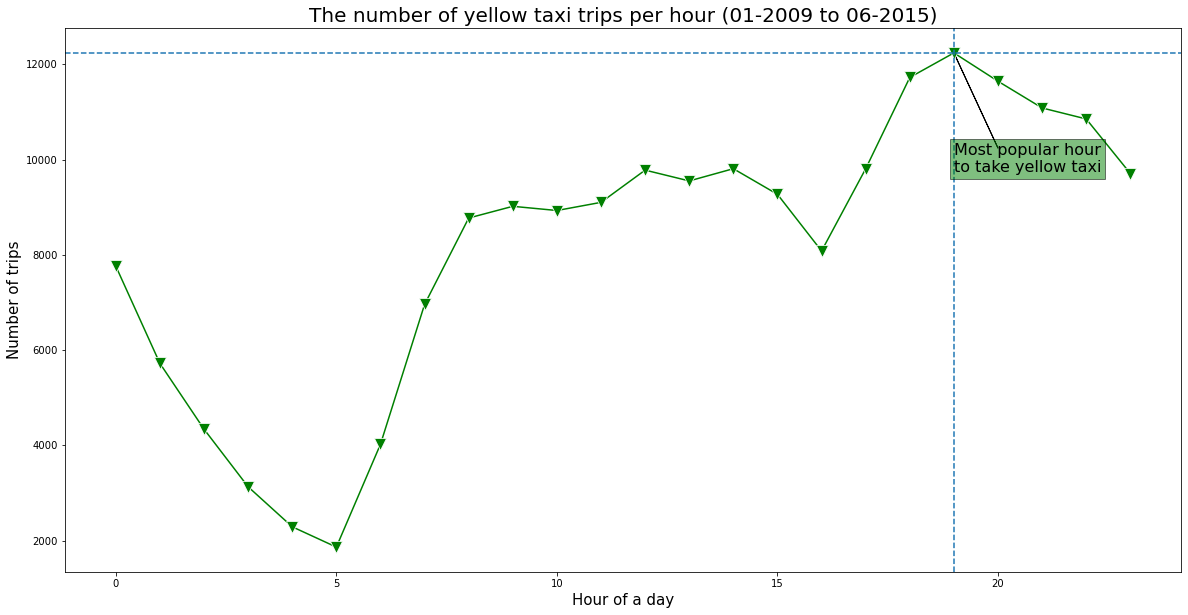

In [45]:
dataframe1 = pd.DataFrame(ans_1)
plot_hour_trip_count(dataframe1)

### Visualization 2 
Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization

In [46]:
def avg_distance_per_month() -> None:
    # process data
    sql_code = """
    select 
        strftime('%m',pickup_datetime) as month, 
        trip_distance
    from uber_trips
    union all
    select 
        strftime('%m',pickup_datetime) as month, 
        trip_distance
    from taxi_trips
    """
    df_distance= pd.DataFrame(engine.execute(sql_code).fetchall())
    df_avg_distance = df_distance.groupby('month')['trip_distance'].agg(['mean', 'std', 'size']).reset_index()
    # calculate 90% confidence interval
    df_avg_distance['t_value'] = df_avg_distance['size'].apply(lambda x: spst.t.ppf((1+0.9)/2, x-1))
    df_avg_distance['CI(left)'] = df_avg_distance['mean'] - df_avg_distance['t_value'] * df_avg_distance['std'] / df_avg_distance['size']**(1/2)
    df_avg_distance['CI(right)'] = df_avg_distance['mean'] + df_avg_distance['t_value'] * df_avg_distance['std'] / df_avg_distance['size']**(1/2)
    # plot
    figure, axes = plt.subplots(figsize=(20, 10))
    sns.lineplot(x='month', y='mean', data=df_avg_distance, color='g', marker='v', markersize=12)
    plt.xlabel('Month', fontsize=15)
    plt.ylabel('Average Distance', fontsize=15)
    axes.set_title("Average distance traveled per month", fontsize=20)
    axes.fill_between(df_avg_distance['month'], 
                    df_avg_distance['CI(left)'], 
                    df_avg_distance['CI(right)'], color='g', alpha=.1)
    plt.show()
#     return df_avg_distance 

2022-04-29 14:29:47,566 INFO sqlalchemy.engine.Engine 
    select 
        strftime('%m',pickup_datetime) as month, 
        trip_distance
    from uber_trips
    union all
    select 
        strftime('%m',pickup_datetime) as month, 
        trip_distance
    from taxi_trips
    
2022-04-29 14:29:47,567 INFO sqlalchemy.engine.Engine [raw sql] ()


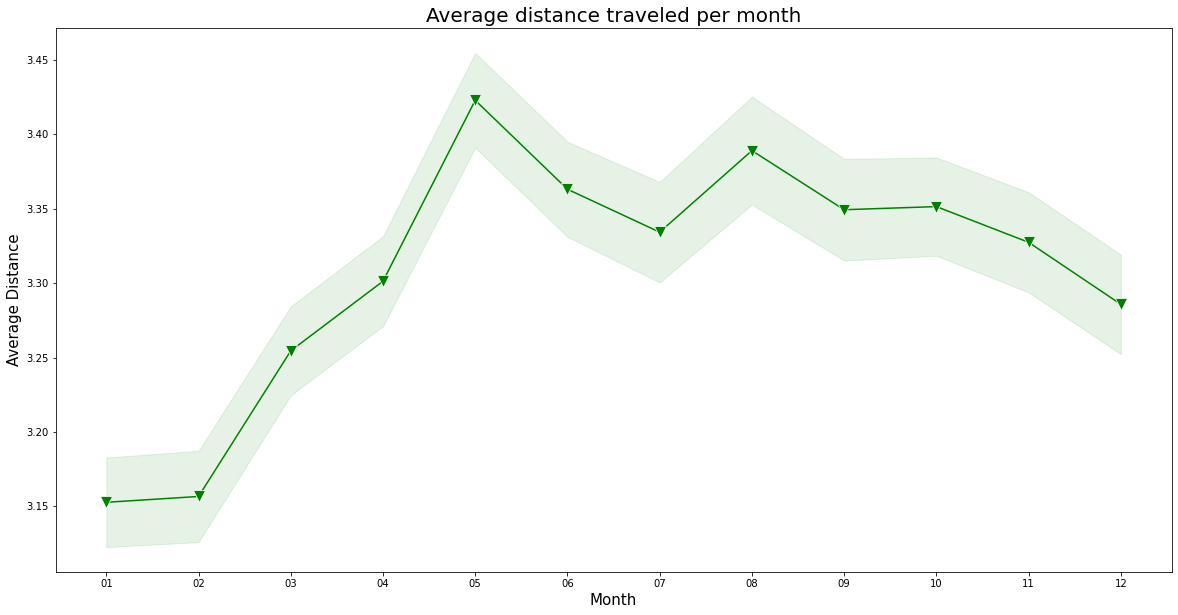

In [47]:
avg_distance_per_month()

### Visualization 3
Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

In [48]:
def airport_visualization() -> None:
    LGA_box = (40.761222,-73.900362,40.784037,-73.837835)
    JFK_box = (40.628724,-73.847431,40.674437,-73.722375)
    EWR_box = (40.669788,-74.240450,40.715473,-74.115394)
    airport_dict = {'LGA airport': LGA_box, 'JFK airport': JFK_box, 'EWR airport': EWR_box}
    df_all_airport = pd.DataFrame()
    popular_day_dict = {}
    for airport_name, airport_box in airport_dict.items():
        log_lb = airport_box[1]
        log_ub = airport_box[3]
        lat_lb = airport_box[0]
        lat_ub = airport_box[2]
        # select data near airport
        sql_code = f"""
        select 
            strftime('%w',pickup_datetime) as day_of_week, 
            trip_distance
        from uber_trips
        where 
            dropoff_longitude between {log_lb} and {log_ub}
            and dropoff_latitude between {lat_lb} and {lat_ub}
        union all
        select 
            strftime('%w',pickup_datetime) as day_of_week, 
            trip_distance
        from taxi_trips
        where 
            dropoff_longitude between {log_lb} and {log_ub}
            and dropoff_latitude between {lat_lb} and {lat_ub}
        """
        df_airport = pd.DataFrame(engine.execute(sql_code).fetchall())
        df_airport_dayofweek = df_airport.groupby('day_of_week').size().reset_index()
        df_airport_dayofweek.columns = ['day_of_week', 'trip_count']
        df_airport_dayofweek['airport_name'] = airport_name # add airport label
        df_all_airport = pd.concat([df_airport_dayofweek, df_all_airport])
        # find the most popular day-of-week
        most_trip = df_airport_dayofweek['trip_count'].max()
        day = df_airport_dayofweek[df_airport_dayofweek['trip_count']==most_trip]['day_of_week'].values[0]
        popular_day_dict[airport_name] = [int(day), most_trip]
    # plot
    figure, axes = plt.subplots(figsize=(15, 8))
    sns.lineplot(x='day_of_week', y='trip_count', data=df_all_airport, hue='airport_name', palette='mako')
    plt.xlabel('Day of week (0 = Sunday)', fontsize=10)
    plt.ylabel('Number of trips', fontsize=10)
    plt.legend()
    axes.set_title("The number of dropoffs per day-of-week at Airport", fontsize=10)
    # add textbox to the most popular day of each airport
    for airport_name, airport_data in popular_day_dict.items():
        plt.text(airport_data[0]-0.5, airport_data[1], f'Most popular day-of-week\nto dropoff at {airport_name}', fontsize = 10,
                 bbox = dict(facecolor = 'b', alpha = 0.5), color='w')
    plt.show()

2022-04-29 14:29:50,115 INFO sqlalchemy.engine.Engine 
        select 
            strftime('%w',pickup_datetime) as day_of_week, 
            trip_distance
        from uber_trips
        where 
            dropoff_longitude between -73.900362 and -73.837835
            and dropoff_latitude between 40.761222 and 40.784037
        union all
        select 
            strftime('%w',pickup_datetime) as day_of_week, 
            trip_distance
        from taxi_trips
        where 
            dropoff_longitude between -73.900362 and -73.837835
            and dropoff_latitude between 40.761222 and 40.784037
        
2022-04-29 14:29:50,116 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-29 14:29:50,171 INFO sqlalchemy.engine.Engine 
        select 
            strftime('%w',pickup_datetime) as day_of_week, 
            trip_distance
        from uber_trips
        where 
            dropoff_longitude between -73.847431 and -73.722375
            and dropoff_latitude between 40.628724 

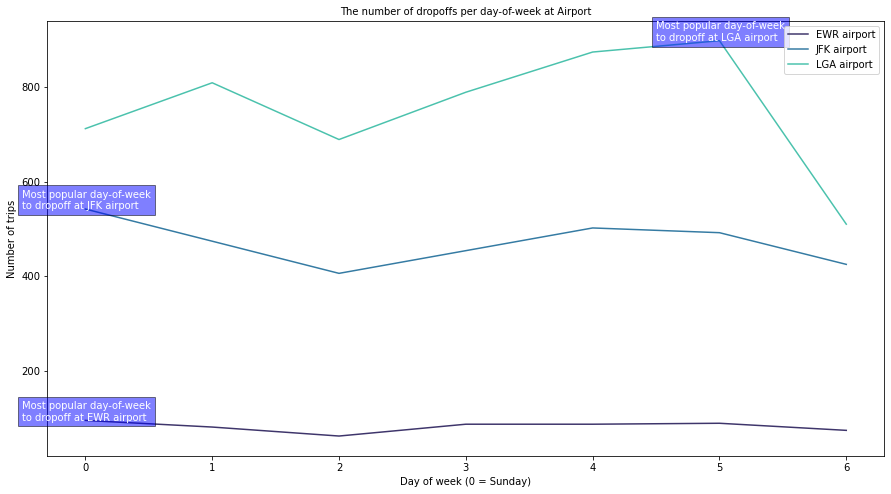

In [49]:
airport_visualization()

### Visualization 4
Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

In [50]:
def heatmap_trip_map(is_pickup: bool) -> None:
    sql_code = f"""
    select pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    from uber_trips
    union all
    select pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    from taxi_trips
    """
    df_map = pd.DataFrame(engine.execute(sql_code).fetchall())
    # setup config for KeplerGl
    config = {'version': 'v1',
             'config': {'visState': {'filters': [],
               'layers': [{'id': 'zvjtim',
                 'type': 'heatmap',
                 'config': {'dataId': 'pickup_location',
                  'label': 'pickup',
                  'color': [255, 203, 153],
                  'highlightColor': [252, 242, 26, 255],
                  'columns': {'lat': 'pickup_latitude', 'lng': 'pickup_longitude'},
                  'isVisible': True,
                  'visConfig': {'opacity': 0.8,
                   'colorRange': {'name': 'Global Warming',
                    'type': 'sequential',
                    'category': 'Uber',
                    'colors': ['#5A1846',
                     '#900C3F',
                     '#C70039',
                     '#E3611C',
                     '#F1920E',
                     '#FFC300']},
                   'radius': 10},
                  'hidden': False,
                  'textLabel': [{'field': None,
                    'color': [255, 255, 255],
                    'size': 18,
                    'offset': [0, 0],
                    'anchor': 'start',
                    'alignment': 'center'}]},
                 'visualChannels': {'weightField': None, 'weightScale': 'linear'}}],
               'interactionConfig': {'tooltip': {'fieldsToShow': {'pickup_location': []},
                 'compareMode': False,
                 'compareType': 'absolute',
                 'enabled': True},
                'brush': {'size': 0.5, 'enabled': False},
                'geocoder': {'enabled': False},
                'coordinate': {'enabled': False}},
               'layerBlending': 'normal',
               'splitMaps': [],
               'animationConfig': {'currentTime': None, 'speed': 1}}}}
    # choose pickup or dropoff location to visualize in heatmap
    if is_pickup:
        map_1 = KeplerGl(height=400, 
                         data={"pickup_location": df_map[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']]}, 
                         config=config)
    else:
        map_1 = KeplerGl(height=400, data={"dropoff_location": df_map[['dropoff_longitude', 'dropoff_latitude']]}, config=config)
    return map_1

In [57]:
heatmap_trip_map(is_pickup=True)
# if you want to see the heatmap of dropoff location, use:
# heatmap_trip_map(is_pickup=False)

2022-04-29 14:40:20,664 INFO sqlalchemy.engine.Engine 
    select pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    from uber_trips
    union all
    select pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    from taxi_trips
    
2022-04-29 14:40:20,664 INFO sqlalchemy.engine.Engine [raw sql] ()
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'zvjtim', 'type': '…

### Visualization 5
Create a scatter plot that compares tip amount versus distance.

In [58]:
def scatter_tip_distance() -> None:
    sql_code = f"""
    select tip_amount, trip_distance
    from taxi_trips
    """
    df_tip_dist = pd.DataFrame(engine.execute(sql_code).fetchall())
    # plot
    figure, axes = plt.subplots(figsize=(10, 8))
    sns.scatterplot(x='trip_distance', y='tip_amount', data=df_tip_dist, color='g')
    plt.xlabel('trip_distance', fontsize=10)
    plt.ylabel('tip_amount', fontsize=10)
    axes.set_title("Scatter plot: tip amount V.S. distance.", fontsize=10)
    plt.show()

2022-04-29 14:40:26,426 INFO sqlalchemy.engine.Engine 
    select tip_amount, trip_distance
    from taxi_trips
    
2022-04-29 14:40:26,426 INFO sqlalchemy.engine.Engine [raw sql] ()


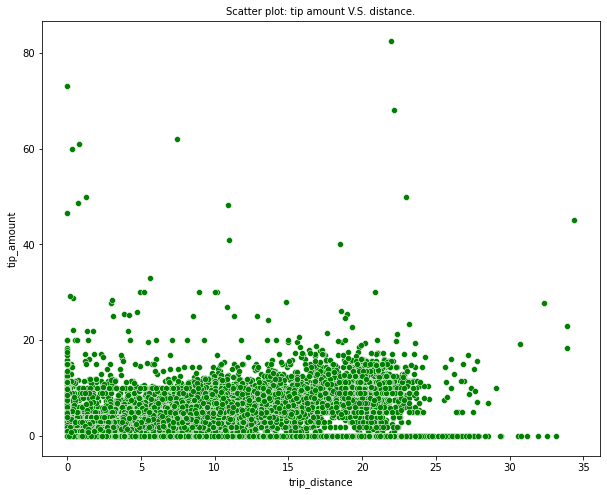

In [59]:
scatter_tip_distance()

### Visualization 6
Create another scatter plot that compares tip amount versus precipitation amount.

Note: I deleted data points with no precipitation.

In [60]:
def scatter_tip_perc() -> None:
    sql_code_1 ="""
    select strftime('%Y-%m-%d %H',date) as date_hour, HourlyPrecipitation
    from hourly_weather
    where HourlyPrecipitation != 0
    """
    sql_code_2 = """
    select strftime('%Y-%m-%d %H',pickup_datetime) as date_hour, tip_amount
    from taxi_trips
    """
    df_perc_hr = pd.DataFrame(engine.execute(sql_code_1).fetchall())
    df_tip_hr = pd.DataFrame(engine.execute(sql_code_2).fetchall())
    df_tip_perc = pd.merge(df_perc_hr, df_tip_hr, how='inner', on='date_hour')
    # scatter plot
    figure, axes = plt.subplots(figsize=(10, 8))
    sns.scatterplot(x='HourlyPrecipitation', y='tip_amount', data=df_tip_perc, color='g')
    plt.xlabel('Hourly Precipitation', fontsize=10)
    plt.ylabel('Tip Amount', fontsize=10)
    axes.set_title("Scatter plot: Tip Amount V.S. Hourly Precipitation.", fontsize=10)
    plt.show()

2022-04-29 14:40:27,103 INFO sqlalchemy.engine.Engine 
    select strftime('%Y-%m-%d %H',date) as date_hour, HourlyPrecipitation
    from hourly_weather
    where HourlyPrecipitation != 0
    
2022-04-29 14:40:27,104 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-29 14:40:27,212 INFO sqlalchemy.engine.Engine 
    select strftime('%Y-%m-%d %H',pickup_datetime) as date_hour, tip_amount
    from taxi_trips
    
2022-04-29 14:40:27,213 INFO sqlalchemy.engine.Engine [raw sql] ()


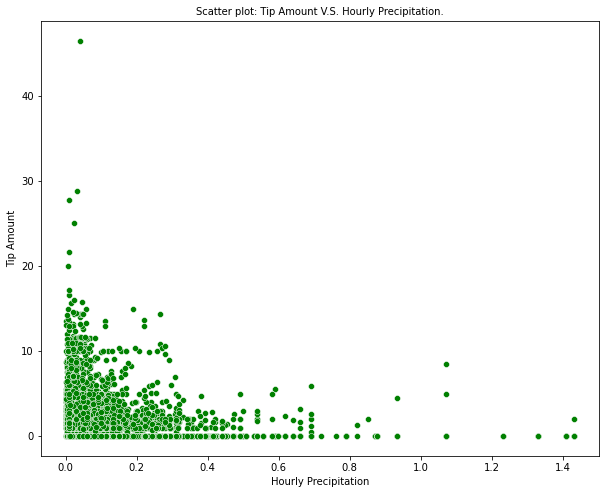

In [61]:
scatter_tip_perc()

### Visualization 7
Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.

#### Question 1 
Which day of week has the largest taxi fare amount per km on average?

In [62]:
def dayofweek_price() -> None:
    sql_code = f"""
    select strftime('%w',pickup_datetime) as day_of_week, fare_amount/trip_distance as price_per_km
    from uber_trips
    union all
    select strftime('%w',pickup_datetime) as day_of_week, (total_amount-tip_amount)/trip_distance as price_per_km
    from taxi_trips
    """
    df_fare = pd.DataFrame(engine.execute(sql_code).fetchall())
    # group by day_of_week to calculate average fare amount
    df_fare_dayofweek = df_fare.groupby('day_of_week')['price_per_km'].mean().reset_index()
    # plot
    figure, axes = plt.subplots(figsize=(15, 8))
    sns.barplot(x='day_of_week', y='price_per_km', data=df_fare_dayofweek, color='g')
    plt.xlabel('day of week (0: Sunday)', fontsize=10)
    plt.ylabel('fare amount per km', fontsize=10)
    axes.set_title("Average taxi fare amount per km on each day-of-week", fontsize=10)
    max_amount = df_fare_dayofweek['price_per_km'].max()
    expensive_day = df_fare_dayofweek[df_fare_dayofweek['price_per_km']==max_amount]['day_of_week'].values[0]
    plt.text(int(expensive_day)-0.3, max_amount-1, f'Most expensive\nday-of-week', 
             fontsize = 10, bbox = dict(facecolor = 'b', alpha = 0.5), color='w')
    plt.show()

2022-04-29 14:40:28,438 INFO sqlalchemy.engine.Engine 
    select strftime('%w',pickup_datetime) as day_of_week, fare_amount/trip_distance as price_per_km
    from uber_trips
    union all
    select strftime('%w',pickup_datetime) as day_of_week, (total_amount-tip_amount)/trip_distance as price_per_km
    from taxi_trips
    
2022-04-29 14:40:28,439 INFO sqlalchemy.engine.Engine [raw sql] ()


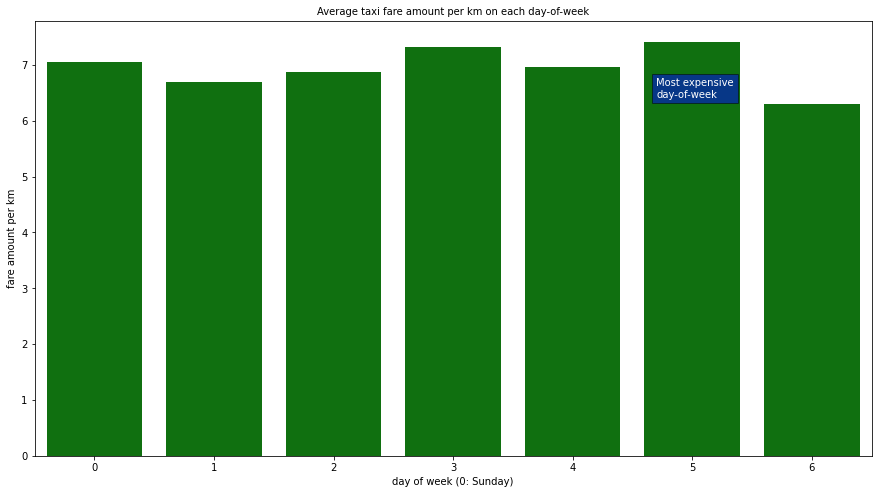

In [63]:
dayofweek_price()

Answer: Friday has the largest taxi fare amount per km on average among all days of week.

#### Question 2 
Is taxi fare amount per km related to precipitation?

In [64]:
def scatter_fare_precipitation() -> None:
    sql_code = f"""
    with taxi_fare_tmp as
        (select hour, avg(price_per_km) as avg_fare_per_km
        from
        (
            select 
                strftime('%Y-%m-%d %H',pickup_datetime) as hour, 
                fare_amount/trip_distance as price_per_km
            from uber_trips
            union all
            select 
                strftime('%Y-%m-%d %H',pickup_datetime) as hour, 
                (total_amount-tip_amount)/trip_distance as price_per_km
            from taxi_trips
        )
        group by hour)
    
    select taxi.hour, taxi.avg_fare_per_km,weather.HourlyPrecipitation
    from taxi_fare_tmp taxi
    join 
    (
        select strftime('%Y-%m-%d %H',date) as hour, HourlyPrecipitation
        from hourly_weather
        where HourlyPrecipitation != 0
    ) weather
    on taxi.hour = weather.hour
    where HourlyPrecipitation != 0
    """
    df_fare_prec = pd.DataFrame(engine.execute(sql_code).fetchall())
    # use scatter plot to find relationship between average fare per km and average precipitation 
    figure, axes = plt.subplots(figsize=(10, 8))
    sns.regplot(x='HourlyPrecipitation', y='avg_fare_per_km', data=df_fare_prec, color='g')
    plt.xlabel('Hourly Precipitation', fontsize=10)
    plt.ylabel('Average fare per km', fontsize=10)
    axes.set_title("Scatter plot: fare per km V.S. precipitation", fontsize=10)
    plt.xlim([-0.01, 1.4])
    plt.ylim([-0.1, 200])
    plt.show()

2022-04-29 14:40:29,570 INFO sqlalchemy.engine.Engine 
    with taxi_fare_tmp as
        (select hour, avg(price_per_km) as avg_fare_per_km
        from
        (
            select 
                strftime('%Y-%m-%d %H',pickup_datetime) as hour, 
                fare_amount/trip_distance as price_per_km
            from uber_trips
            union all
            select 
                strftime('%Y-%m-%d %H',pickup_datetime) as hour, 
                (total_amount-tip_amount)/trip_distance as price_per_km
            from taxi_trips
        )
        group by hour)
    
    select taxi.hour, taxi.avg_fare_per_km,weather.HourlyPrecipitation
    from taxi_fare_tmp taxi
    join 
    (
        select strftime('%Y-%m-%d %H',date) as hour, HourlyPrecipitation
        from hourly_weather
        where HourlyPrecipitation != 0
    ) weather
    on taxi.hour = weather.hour
    where HourlyPrecipitation != 0
    
2022-04-29 14:40:29,570 INFO sqlalchemy.engine.Engine [raw sql] ()


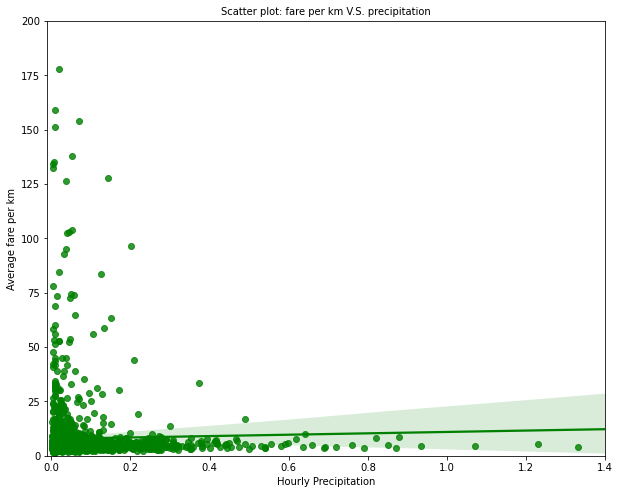

In [65]:
scatter_fare_precipitation()

Answer: taxi fare amount distance and precipitation are positively correlated.

#### Question 3
How did the precipitation in NYC change over time?

In [66]:
def precipitation_time() -> None:
    sql_code = """
    select 
       strftime('%Y-%m',date) as month,
       avg(HourlyPrecipitation) as avg_hourly_precipitation
    from hourly_weather
    group by strftime('%Y-%m',date)
    """
    df_prec_time = pd.DataFrame(engine.execute(sql_code).fetchall())
    # plot the time series of NYC precipitation
    figure, axes = plt.subplots(figsize=(20, 10))
    sns.lineplot(x='month', y='avg_hourly_precipitation', data=df_prec_time, color='g')
    plt.xticks(rotation = 90)
    max_perc_month = df_prec_time['month'][df_prec_time['avg_hourly_precipitation'].idxmax()]
    plt.axvline(x=max_perc_month, linestyle='--')
    plt.show()

2022-04-29 14:40:31,993 INFO sqlalchemy.engine.Engine 
    select 
       strftime('%Y-%m',date) as month,
       avg(HourlyPrecipitation) as avg_hourly_precipitation
    from hourly_weather
    group by strftime('%Y-%m',date)
    
2022-04-29 14:40:31,995 INFO sqlalchemy.engine.Engine [raw sql] ()


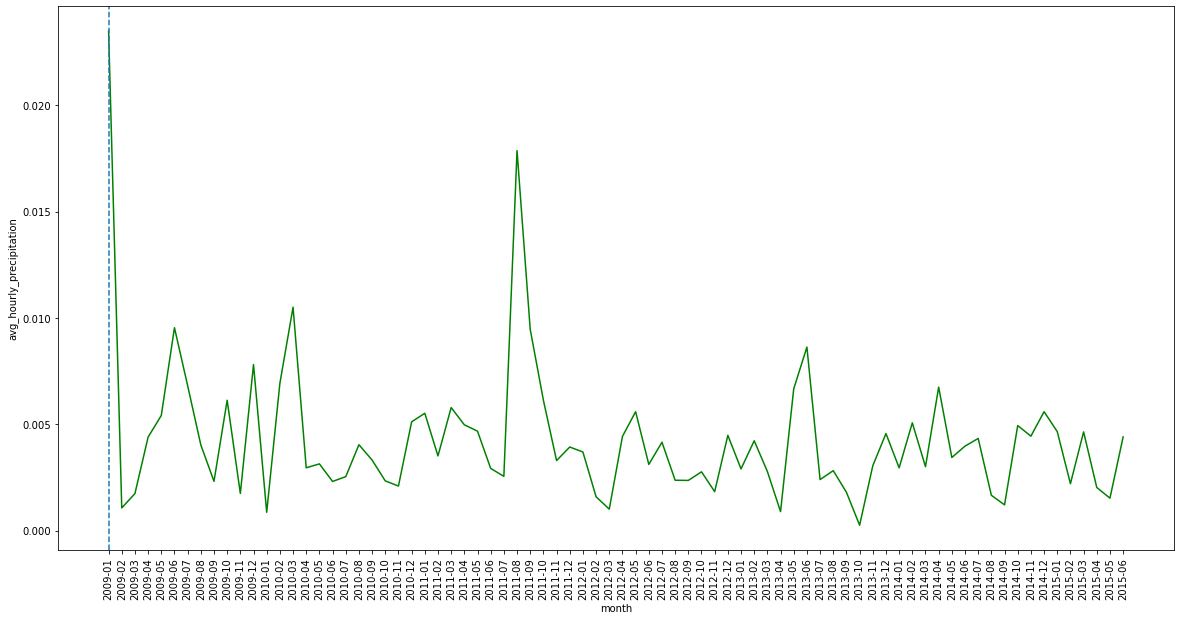

In [67]:
precipitation_time()

Answer: The average hourly precipitation has a slightely declining trend over time.